In [120]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.patches as mpatches

from classes.classes import MODEL_CONFIGS, NO_COSTS_MODEL_CONFIGS
from classes.paths import LocalPaths
from classes.workloads import EvalWorkloads
from cross_db_benchmark.datasets.datasets import Database
from evaluation.eval import Evaluator
from evaluation.evaluation_metrics import QError, PickRate, SelectedRuntime
from evaluation.utils import get_model_results, draw_metric, draw_predictions
from training.dataset.dataset_creation import read_workload_runs
from classes.classes import ColorManager
import seaborn
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from classes.classes import DACEModelConfig, QueryFormerModelConfig, ZeroShotModelConfig, E2EModelConfig, \
    ScaledPostgresModelConfig, FlatModelConfig, QPPNetModelConfig
from classes.classes import MSCNModelConfig
from matplotlib.font_manager import FontProperties
from matplotlib.patches import Rectangle


sns.set_theme(style="whitegrid", font_scale=1.8)
fontsize=12

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Evaluate Plans

In [2]:
evaluator = Evaluator()
metrics = [QError(), PickRate(), SelectedRuntime(display_name="Selected\nRuntime")]
workloads =[EvalWorkloads.PhysicalPlan.imdb, EvalWorkloads.PhysicalPlan.tpc_h_pk, EvalWorkloads.PhysicalPlan.baseball]
databases = [Database("scale", display_name="IMDB"), Database("tpc_h_pk", display_name="TPC-H"), Database("baseball", display_name="Baseball")]
model_confs = MODEL_CONFIGS #+ NO_COSTS_MODEL_CONFIGS
seeds = [0, 1, 2]

for workload in workloads:
    evaluator.eval(workloads=workload,
                   metrics=metrics,
                   plot_single_workloads=False,
                   plot_limit=5,
                   seeds=[0, 1, 2],
                   model_configs=model_confs)

Cardinalities missing for plan tpc_h_103
Cardinalities missing for plan tpc_h_1062
Cardinalities missing for plan tpc_h_1147
Cardinalities missing for plan tpc_h_1273
Cardinalities missing for plan tpc_h_1303
Cardinalities missing for plan tpc_h_1428
Cardinalities missing for plan tpc_h_1546
Cardinalities missing for plan tpc_h_160
Cardinalities missing for plan tpc_h_179
Cardinalities missing for plan tpc_h_216
Cardinalities missing for plan tpc_h_278
Cardinalities missing for plan tpc_h_358
Cardinalities missing for plan tpc_h_454
Cardinalities missing for plan tpc_h_504
Cardinalities missing for plan tpc_h_768
Cardinalities missing for plan tpc_h_822
Cardinalities missing for plan tpc_h_827
Cardinalities missing for plan tpc_h_884
Cardinalities missing for plan tpc_h_970
Cardinalities missing for plan baseball_1003
Cardinalities missing for plan baseball_1016
Cardinalities missing for plan baseball_1081
Cardinalities missing for plan baseball_1146
Cardinalities missing for plan base

## 2. Create Anecdote Plots

/var/folders/6f/l772vx1s4zd9xhd99kx9535h0000gn/T/ipykernel_89634/672035653.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  prediction_ax.set_xticklabels(["Real Runtime", ""] + [m.name.DISPLAY_NAME for m in model_confs], fontsize=fontsize * 0.8, rotation=45)
/var/folders/6f/l772vx1s4zd9xhd99kx9535h0000gn/T/ipykernel_89634/672035653.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  prediction_ax.set_xticklabels(workload.yticks, fontsize=fontsize)
/var/folders/6f/l772vx1s4zd9xhd99kx9535h0000gn/T/ipykernel_89634/672035653.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  prediction_ax.set_xticklabels(["Real Runtime", ""] + [m.name.DISPLAY_NAME for m in model_confs], fontsize=fontsize, rotation=45, ha='right')


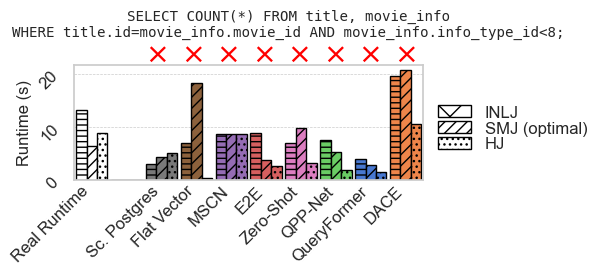

In [110]:
# General settings
path = LocalPaths().data / "plots" / "physical_plan_anecdote.pdf"
mosaic = """AAAABB\nAAAABB"""
model_confs = MODEL_CONFIGS
workload = workloads[0][1]
sort_map = {model.name.DISPLAY_NAME: i for i, model in enumerate(model_confs)}
sort_map["Real\nRuntime"] = -1
sort_map["x"] = 0
hatch_patterns = {0: "---", 1: "///", 2: "...", 3: "x"}
checkmark_font = FontProperties(family='DejaVu Sans', size=18)

# Read out results
results = get_model_results(workload, model_confs)
real_runtime = results.groupby("query_index")["runtime"].min().reset_index()
real_runtime["model"] = "Real\nRuntime"
real_runtime["prediction"] = real_runtime["runtime"]
real_runtime["label"] = real_runtime["runtime"]
real_runtime["runtime"] = real_runtime["runtime"]
real_runtime["selected_runtime"] = real_runtime["runtime"]
results = pd.concat([results, real_runtime], ignore_index=True)
results = pd.concat([results.iloc[:0], pd.DataFrame({'model': ['x'], 'query_index': [0], 'prediction': [0]}), results.iloc[0:]])
results = pd.concat([results.iloc[:0], pd.DataFrame({'model': ['x'], 'query_index': [1], 'prediction': [0]}), results.iloc[0:]])
results = pd.concat([results.iloc[:0], pd.DataFrame({'model': ['x'], 'query_index': [2], 'prediction': [0]}), results.iloc[0:]])
results = results.sort_values(by=['model', 'query_index'], key=lambda x: x.map(sort_map))

figure = plt.figure(figsize=(4.5, 1.5), dpi=100)
prediction_ax = figure.subplots(1, 1)

bars = seaborn.barplot(x="model", 
                hue="query_index", 
                y="prediction", 
                data=results, 
                ax=prediction_ax, 
                errorbar=None,
                edgecolor='black',
                width=0.9) 

prediction_ax.set_xticklabels(["Real Runtime", ""] + [m.name.DISPLAY_NAME for m in model_confs], fontsize=fontsize * 0.8, rotation=45)

bar_groups = []
all_labels = bars.get_xticklabels() * 3
for i, bar in enumerate(bars.patches[0:30]):
    label = all_labels[i].get_text()
    row = {"x": bar.get_x(), "model":  label, "bar": bar, "hatch": i // 10}
    bar_groups.append(row)
# Sort bar groups by x position
bar_groups = sorted(bar_groups, key=lambda x: x['x'])

# Set background color for each group of bars (grouped by model)
for bar_group in bar_groups:
    color = ColorManager.COLOR_PALETTE.get(bar_group["model"], 'white')
    bar_group["bar"].set_facecolor(color)
    bar_group["bar"].set_hatch(hatch_patterns[bar_group["hatch"]])

# Configure plot
prediction_ax.set_ylabel("Runtime (s)", fontsize=fontsize)
prediction_ax.grid(axis="y", which='both', linestyle='--', linewidth=0.5)
prediction_ax.set_xlabel("")
prediction_ax.set_xticklabels(workload.yticks, fontsize=fontsize)
prediction_ax.tick_params(axis='x', rotation=45, labelsize=fontsize, pad=-4)
prediction_ax.tick_params(axis='y', rotation=45, labelsize=fontsize)
prediction_ax.set_xticklabels(["Real Runtime", ""] + [m.name.DISPLAY_NAME for m in model_confs], fontsize=fontsize, rotation=45, ha='right')
prediction_ax.get_legend().remove()

for (x, symbol) in zip(range(1, 1 + len(MODEL_CONFIGS)), 8 * ['⨯']):
    prediction_ax.annotate(xy=(0.102 * (x + 0.99), 1.02), xycoords='axes fraction', text=symbol, rotation=0, fontproperties=checkmark_font, color="red", fontsize=fontsize * 1.7)

# Draw common legend
#handles, labels = prediction_ax.get_legend_handles_labels()
handles = [
    Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', label='INLJ', hatch=hatch_patterns[3]),
    Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', label='SMJ (optimal)', hatch=hatch_patterns[1]),
    Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', label='HJ', hatch=hatch_patterns[2])]

legend = prediction_ax.legend(
    handles=handles,
    fontsize=fontsize,
    ncol=1, 
    loc='center left', 
    columnspacing=1, 
    bbox_to_anchor=(1., 0.45),
    labelspacing=0.05,
    edgecolor='white')

figure.suptitle("SELECT COUNT(*) FROM title, movie_info\nWHERE title.id=movie_info.movie_id AND movie_info.info_type_id<8;",
                fontsize=fontsize*0.85, 
                fontproperties={'family':'monospace'},
                y=1.25, 
                x=0.6, 
                horizontalalignment='center')
# Save plot
figure.savefig(path, bbox_inches='tight')

In [44]:
results

,model,query_index,label,prediction,runtime,act_card,est_card,selected_runtime
24,Real Runtime,0,13.193829,13.193829,13.193829,NaN,NaN,13.193829
25,Real Runtime,1,6.478269,6.478269,6.478269,NaN,NaN,6.478269
26,Real Runtime,2,8.946130,8.946130,8.946130,NaN,NaN,8.946130
0,,2,NaN,NaN,NaN,NaN,NaN,NaN
0,,1,NaN,NaN,NaN,NaN,NaN,NaN
0,,0,NaN,NaN,NaN,NaN,NaN,NaN
6,Sc. Postgres,0,13.193829,3.105777,13.193829,58891109.0,58891109.0,NaN
14,Sc. Postgres,1,6.478269,4.316334,6.478269,102602969.0,102602969.0,NaN
22,Sc. Postgres,2,8.946130,5.174375,8.946130,29147497.0,29147497.0,NaN
2,Flat Vector,0,13.193829,7.010701,13.193829,58891109.0,58891109.0,NaN


In [121]:
evaluator = Evaluator()
workloads =[EvalWorkloads.PhysicalPlan.imdb, EvalWorkloads.PhysicalPlan.tpc_h_pk, EvalWorkloads.PhysicalPlan.baseball]
model_confs = NO_COSTS_MODEL_CONFIGS
seeds = [0, 1, 2]
metrics = [QError(), PickRate(), SelectedRuntime()]
for workload in workloads:
    evaluator.eval(workloads=workload,
                   metrics=metrics,
                   plot_single_workloads=False,
                   plot_limit=5,
                   seeds=[0, 1, 2],
                   model_configs=model_confs)

Cardinalities missing for plan tpc_h_103
Cardinalities missing for plan tpc_h_1062
Cardinalities missing for plan tpc_h_1147
Cardinalities missing for plan tpc_h_1273
Cardinalities missing for plan tpc_h_1303
Cardinalities missing for plan tpc_h_1428
Cardinalities missing for plan tpc_h_1546
Cardinalities missing for plan tpc_h_160
Cardinalities missing for plan tpc_h_179
Cardinalities missing for plan tpc_h_216
Cardinalities missing for plan tpc_h_278
Cardinalities missing for plan tpc_h_358
Cardinalities missing for plan tpc_h_454
Cardinalities missing for plan tpc_h_504
Cardinalities missing for plan tpc_h_768
Cardinalities missing for plan tpc_h_822
Cardinalities missing for plan tpc_h_827
Cardinalities missing for plan tpc_h_884
Cardinalities missing for plan tpc_h_970
Cardinalities missing for plan baseball_1003
Cardinalities missing for plan baseball_1016
Cardinalities missing for plan baseball_1081
Cardinalities missing for plan baseball_1146
Cardinalities missing for plan base

/var/folders/6f/l772vx1s4zd9xhd99kx9535h0000gn/T/ipykernel_89634/3508868519.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  pick_rate.set_yticklabels(pick_rate.get_yticklabels(), fontsize=fontsize)
/var/folders/6f/l772vx1s4zd9xhd99kx9535h0000gn/T/ipykernel_89634/3508868519.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  pick_rate.set_yticklabels(pick_rate.get_yticklabels(), fontsize=fontsize)
/var/folders/6f/l772vx1s4zd9xhd99kx9535h0000gn/T/ipykernel_89634/3508868519.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  pick_rate.set_yticklabels(pick_rate.get_yticklabels(), fontsize=fontsize)
/var/folders/6f/l772vx1s4zd9xhd99kx9535h0000gn/T/ipykernel_89634/3508868519.py:119: UserWarning: You have used the `textcoords` kwarg, but 

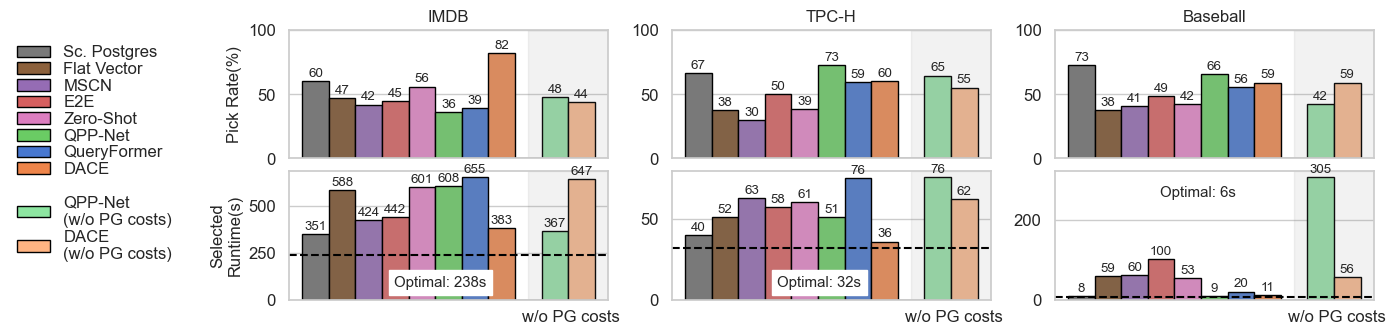

In [131]:
path = LocalPaths().data / "plots" /"physical_plan_selection_full.pdf"
databases = [Database("scale", display_name="IMDB"), Database("tpc_h", display_name="TPC-H"), Database("baseball", display_name="Baseball")]

# Plotting
results = pd.DataFrame.from_dict(evaluator.metric_collection)
results["database"] = results["workload"].str.rsplit('_', n=1).str[0]
results["workload"] = results["workload"].str.rsplit('_', n=1).str[-1]

fig, (upper_axs, lower_axs) = plt.subplots(2, 3, figsize=(14, 3.5), sharex="col", dpi=100)
for i, database in enumerate(databases):
    if database.db_name == "scale":
        min_runtime = sum(evaluator.minimal_runtimes["imdb"])
    elif database.db_name == "tpc_h":
        min_runtime = sum(evaluator.minimal_runtimes["tpc_h_pk"])
    else: 
        min_runtime = sum(evaluator.minimal_runtimes[database.db_name])
    pick_rate, runtime = upper_axs[i], lower_axs[i]

    # Prepare dataframes
    result_df = results[results["database"] == database.db_name]
    #print(result_df)
    # Get workload where q-error is > 10.000 and remove all entries corresponding to the workload
    high_q_error_workloads = result_df[result_df["qerror"] > 100000]["workload"].unique()
    min_runtime = min_runtime - results[results["workload"].isin(high_q_error_workloads)]["runtime"].sum()
    result_df = result_df[~result_df["workload"].isin(high_q_error_workloads)]
    
    percentage_true = result_df.groupby('model_name')['pick_rate'].mean() * 100
    percentage_true = percentage_true.reindex([c.name.DISPLAY_NAME for c in model_confs])
    runtimes = result_df.groupby('model_name')['runtime'].sum()
    runtimes = runtimes.reindex([c.name.DISPLAY_NAME for c in model_confs])
    
    palette = ColorManager.COLOR_PALETTE
    # Insert an empty value
    model_names = list([c.name.DISPLAY_NAME for c in model_confs])
    empty_entry = 'empty'
    empty_color = 'white'  # Use the background color of your plot
    palette[empty_entry] = empty_color
    percentage_true[empty_entry] = 0
    runtimes[empty_entry] = 0

    # Insert the empty entry between the sixth and seventh bars
    insert_position = 8  # Index to insert the empty bar
    model_names.insert(insert_position, empty_entry)
    
    # Reindex the dataframes to include the empty entry
    percentage_true = percentage_true.reindex(model_names)
    runtimes = runtimes.reindex(model_names)

    # Melt the dataframes
    percentage_true_df = percentage_true.reset_index().melt(id_vars='model_name', var_name='variable', value_name='value')
    runtimes_df = runtimes.reset_index().melt(id_vars='model_name', var_name='variable', value_name='value')
        
    sns.barplot(data=percentage_true_df, 
                x="model_name", 
                y="value", 
                ax=pick_rate,
                palette=palette, 
                width=1.0, 
                log_scale=(False, False),
                hue="model_name",
                edgecolor='black')
    
    # Add bar labels
    for idx, c in enumerate(pick_rate.containers):
        if idx != 8:
            pick_rate.bar_label(c, fontsize=0.8 * fontsize, fmt='%.0f', padding=1, label_type='edge')

    pick_rate.set_ylim(0, 100)
    pick_rate.grid(False, axis='x', which='both')
    pick_rate.grid(True, axis='y', which='both')
    pick_rate.set_xlabel('')
    pick_rate.set_ylabel('')
    pick_rate.axvspan(xmin=8, xmax=11, alpha=0.1, color='gray')
    pick_rate.set_title(database.display_name, fontsize=fontsize)
    pick_rate.set_yticklabels(pick_rate.get_yticklabels(), fontsize=fontsize)
    pick_rate.set_xlim(left=-1, right=10)

    # Plot the runtimes
    sns.barplot(data=runtimes_df,
                x="model_name", 
                y="value", 
                ax=runtime, 
                width=1.0, 
                palette=ColorManager.COLOR_PALETTE, 
                hue="model_name", 
                edgecolor='black')
    
    # Add bar labels
    for idx, c in enumerate(runtime.containers):
        if idx != 8:
            runtime.bar_label(c, fontsize=0.8 * fontsize, fmt='%.0f', padding=1, label_type='edge')
        
    #runtime.set_yscale('log')
    runtime.set_xlabel('')
    runtime.set_ylabel('')
    runtime.set_xlim(left=-1, right=11)
    runtime.axhline(min_runtime, color='black', linestyle='--')
    if database.db_name in ["scale", "tpc_h"]:
        xy = (0.33, 0.1)
    else:
        xy = (0.33, 0.8)
    runtime.annotate(f"Optimal: {min_runtime:.0f}s", 
                     xy=xy, 
                     xytext=xy, 
                     fontsize=fontsize * 0.9, 
                     xycoords="axes fraction",
                     backgroundcolor='white')
    
    runtime.grid(False, axis='x', which='both')
    runtime.grid(True, axis='y', which='both')
    runtime.axvspan(xmin=8, xmax=11, alpha=0.1, color='gray')
    runtime.set_xticklabels([], fontsize=fontsize)
    runtime.yaxis.set_tick_params(labelsize=fontsize, which='both')

# Set axis labels
upper_axs[0].set_ylabel('Pick Rate(%)', fontsize=fontsize)
lower_axs[0].set_ylabel('Selected\nRuntime(s)', fontsize=fontsize)

lower_axs[0].annotate('w/o PG costs', xy=(0.88, -0.08), xycoords='axes fraction', textcoords='offset points',  ha='center', va='top', fontsize=fontsize)
lower_axs[1].annotate('w/o PG costs', xy=(0.88, -0.08), xycoords='axes fraction', textcoords='offset points',  ha='center', va='top', fontsize=fontsize)
lower_axs[2].annotate('w/o PG costs', xy=(0.88, -0.08), xycoords='axes fraction', textcoords='offset points',  ha='center', va='top', fontsize=fontsize)

# Draw legend
legend_patches = [mpatches.Patch(color=model_config.color(), label=model_config.name.DISPLAY_NAME) for model_config in model_confs]

for p in legend_patches:
    p.set_edgecolor('black')

blank_line = plt.Line2D([], [], linewidth=0)
legend_patches.insert(8, blank_line)
upper_axs[0].legend(handles=legend_patches, 
                    loc='upper left', 
                    bbox_to_anchor=(-0.9, 1.0), 
                    fontsize=fontsize,
                    labelspacing=0.1, 
                    facecolor='white', 
                    edgecolor='white')

# Generate plot
plt.subplots_adjust(hspace=0.10)
fig.align_labels()
plt.savefig(path, bbox_inches='tight')

In [ ]:
results

In [ ]:
def get_nested_loop_join_type(plan):
    if plan.plan_parameters.op_name == "Nested Loop":
        join_tables = plan.children
        if join_tables[0].plan_parameters.est_card == 1:
            inner_table = join_tables[0]
            outer_table = join_tables[1]
        else:
            inner_table = join_tables[1]
            outer_table = join_tables[0]
            
        assert outer_table.plan_parameters.est_card > 1
        if "Index" in inner_table.plan_parameters.op_name:
            return "Index Nested Loop"
        else:
            return "Nested Loop"
     
    for subplan in plan.children:
        return get_nested_loop_join_type(subplan)

def get_join_type(plan):
    if "Merge Join" in str(plan):
        return "Merge Join"
    elif "Hash Join" in str(plan):
        return "Hash Join"
    elif "Nested Loop" in str(plan):
        return get_nested_loop_join_type(plan)
    print(plan)

In [ ]:
evaluator = Evaluator()
metrics = [QError(), PickRate(), SelectedRuntime()]
workloads =[EvalWorkloads.PhysicalPlan.imdb, EvalWorkloads.PhysicalPlan.imdb_with_indexes]
databases = [Database("scale", display_name="IMDB")]
model_confs = [
    ScaledPostgresModelConfig(),
    FlatModelConfig(),
    #MSCNModelConfig(),
    E2EModelConfig(),
    ZeroShotModelConfig(),
    QPPNetModelConfig(),
    QueryFormerModelConfig(),
    DACEModelConfig(),
]
seeds = [0, 1, 2]

evaluator.minimal_runtimes = {}
evaluator.metric_collection = []

collected_results = []
collected_runtimes = []
collected_percentages = []
collected_optimal_runtimes = []

for workload in workloads:
    evaluator.eval(workloads=workload,
                   metrics=metrics,
                   plot_single_workloads=False,
                   plot_limit=5,
                   seeds=[0, 1, 2],
                   model_configs=model_confs)

    results = []
    optimal_runtimes = []
    for single_wl in workload:
        plans, database_statistics = read_workload_runs(workload_run_paths=[single_wl.get_workload_path(LocalPaths().parsed_plans)])
        join_types = []
        plan_runtimes = []
        for plan in plans:
            join_types.append(get_join_type(plan))
            plan_runtimes.append(int(plan.plan_runtime))
        optimal_runtimes.append(min(plan_runtimes))
        # Combine model predictions to common dataframe
        predictions = Evaluator.combine_predictions(model_confs, single_wl, seeds)
        # Add join types to predictions by mapping query_index to join type
        mapping = {0: join_types[0], 1: join_types[1], 2: join_types[2]}
        predictions["join_type"] = predictions['query_index'].map(mapping)
        
        # Aggregate and reduce the predictions over the given seeds
        predictions = predictions.groupby(['model', 'query_index', 'label', 'join_type'])['prediction'].mean().reset_index()
        
        # Add optimal plan first
        results.append({"model": "Optimal", "join_type": predictions[predictions["label"] == min(predictions["label"])]["join_type"].values[0], "workload": single_wl.get_workload_name()})
        for model in model_confs:
            model_predictions = predictions[predictions['model'] == model.name.DISPLAY_NAME]
            # Get join_type where prediction is minimal
            
            selected_join = model_predictions[model_predictions["prediction"] == min(model_predictions["prediction"])]["join_type"].values[0]
            
            results.append({"model": model.name.DISPLAY_NAME, 
                            "join_type": selected_join, 
                            "workload": single_wl.get_workload_name()})
    collected_optimal_runtimes.append(sum(optimal_runtimes))

    results = pd.DataFrame.from_dict(results)
    results = results.groupby(['model', 'join_type']).size().unstack().fillna(0).reset_index()
    results.set_index('model', inplace=True)
    results = results.reindex([c.name.DISPLAY_NAME for c in model_confs] + ["Optimal"])
    collected_results.append(results)
    
    
    # Compute pick rates and runtimes    
    min_runtime = sum(evaluator.minimal_runtimes["imdb"])
    results = pd.DataFrame.from_dict(evaluator.metric_collection)
    
    evaluator.metric_collection = []
    evaluator.minimal_runtimes = {}
    results["database"] = results["workload"].str.rsplit('_', n=1).str[0]
    results["workload"] = results["workload"].str.rsplit('_', n=1).str[-1]

    runtimes = results.groupby('model_name')['runtime'].sum()
    runtimes = runtimes.reindex([c.name.DISPLAY_NAME for c in model_confs])
    runtimes = runtimes.reset_index().melt(id_vars='model_name', var_name='variable', value_name='value')
    collected_runtimes.append(runtimes)
    
    percentage_true = results.groupby('model_name')['pick_rate'].mean() * 100
    percentage_true = percentage_true.reindex([c.name.DISPLAY_NAME for c in model_confs])
    percentage_true = percentage_true.reset_index().melt(id_vars='model_name', var_name='variable', value_name='value')
    collected_percentages.append(percentage_true)

In [ ]:
collected_optimal_runtimes

In [ ]:
paths = [LocalPaths().data / "plots" /"physical_plan_breakdown.pdf", 
         LocalPaths().data / "plots" /"physical_plan_breakdown_add_index.pdf"]
fontsize = 16

NUM_SUBPLOTS =  len(model_confs) + 3
COLOR_PALETTE = [sns.color_palette("Grays")[0], sns.color_palette("Grays")[2], sns.color_palette("Grays")[3]]

def custom_autopct(pct):
    return ('%1.0f%%' % pct) if pct >= 10 else ('' % pct)
    
for index, (results, pick_rates, runtimes, actual_runtime, path) in enumerate(zip(collected_results, collected_percentages, collected_runtimes, collected_optimal_runtimes, paths)):
    fig, axes = plt.subplots(1,NUM_SUBPLOTS, figsize=(17, 2), dpi=100)
    optimal_ax, prediction_axs, runtime_ax, pick_rate_ax = axes[0], axes[1:-2], axes[-2], axes[-1]
        
    # Draw optimal results
    optimal_ax.pie(results.loc['Optimal'], 
                autopct=lambda pct: custom_autopct(pct), 
                startangle=90, 
                counterclock=True, 
                labels=['', '', ''], 
                textprops={'fontsize': 11}, 
                pctdistance=0.6, 
                colors=COLOR_PALETTE, 
                wedgeprops={"edgecolor":"k"},
                radius=1.2)
    optimal_ax.set_ylabel('')
    optimal_ax.legend(loc=3, labels=results.columns, fontsize=fontsize * 0.8, bbox_to_anchor=(-2.2, 0.1))
    optimal_ax.set_title('Optimal', fontsize=fontsize, y=1.05)
    
    # Draw model selections
    for prediction_ax, model in zip(prediction_axs, model_confs):
        res = results.loc[model.name.DISPLAY_NAME]
        if not (model == QPPNetModelConfig() and index == 1):
            prediction_ax.pie(res,
                   autopct=lambda pct: custom_autopct(pct), 
                   startangle=90, 
                   counterclock=True, 
                   labels=[" " for _ in range(len(res))], 
                   textprops={'fontsize': 11},  
                   pctdistance=0.6,  
                   colors=COLOR_PALETTE, 
                   radius=1.15,
                   wedgeprops={"edgecolor":"k"})
            prediction_ax.set_ylabel('')
            prediction_ax.set_title(model.name.DISPLAY_NAME, fontsize=fontsize, backgroundcolor=model.color(), y=1.05)

        else: 
            prediction_ax.axis('off')
            prediction_ax.text(0.5, 0.5, "not\nsupported", fontsize=fontsize, ha='center', va='center')
            prediction_ax.set_title(model.name.DISPLAY_NAME, fontsize=fontsize, backgroundcolor=model.color(), y=0.9)
    
    if index == 1:
        pick_rates = pick_rates[pick_rates["model_name"] != "QPP-Net"]
        runtimes = runtimes[runtimes["model_name"] != "QPP-Net"]
        
    # Draw runtimes for each workload
    sns.barplot(data=runtimes,
                x="model_name", 
                y="value", 
                ax=axes[-2], 
                width=1.0, 
                palette=ColorManager.COLOR_PALETTE, 
                hue="model_name", 
                edgecolor='black')
    runtime_ax.set_title("Runtime (s)", fontsize=fontsize, y=1.05)
    runtime_ax.set_ylabel('', fontsize=fontsize)
    runtime_ax.set_xlabel('')
    runtime_ax.set_xticklabels([], fontsize=fontsize)
    runtime_ax.set_ylim(0, 660)
    runtime_ax.set_yticklabels(axes[-2].get_yticklabels(), fontsize=fontsize * 0.8, rotation=45)
    runtime_ax.tick_params(axis="y", pad=-10)
    runtime_ax.axhline(y=actual_runtime / 1000, color='black', linestyle='--', linewidth=2)
    runtime_ax.annotate(f"{round(actual_runtime/1000, 2):.0f}s", xy=(0.3, 0.08), xycoords='axes fraction', fontsize=fontsize * 0.8, backgroundcolor='white')
    
    # Draw pick rates
    sns.barplot(data=pick_rates,
                x="model_name", 
                y="value", 
                ax=pick_rate_ax, 
                width=1.0, 
                palette=ColorManager.COLOR_PALETTE, 
                hue="model_name", 
                edgecolor='black')
    pick_rate_ax.set_ylabel('', fontsize=fontsize)
    pick_rate_ax.set_ylim(0, 100)
    pick_rate_ax.set_xlabel('')
    pick_rate_ax.set_xticklabels([], fontsize=fontsize)
    pick_rate_ax.yaxis.tick_right()
    pick_rate_ax.set_yticklabels(pick_rate_ax.get_yticklabels(), fontsize=fontsize * 0.8, rotation=45)
    pick_rate_ax.set_title("Pick Rate (%)", fontsize=fontsize, y=1.05)

    # Adjust layout
    plt.subplots_adjust(hspace=0.10)
    fig.align_labels()
    plt.savefig(path, bbox_inches='tight')